# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import add_constant, OLS

df = pd.read_csv('cars_hw.csv')

# Drop the column `Unnamed: 0`
df.drop(columns=['Unnamed: 0'], inplace=True)

# Remove 'st', 'nd', 'rd', 'th' from the column `No_of_Owners`
df['No_of_Owners'] = df['No_of_Owners'].str.replace(r'(st|nd|rd|th)', '', regex=True)

# Convert the column `No_of_Owners` to numeric
df['No_of_Owners'] = pd.to_numeric(df['No_of_Owners'])


In [10]:
categorical_cols = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
for col in categorical_cols:
    unique_values = df[col].unique()
    if len(unique_values) > 50:
        print(f'\nUnique values in {col}:')
        print(unique_values)
    else:
        print(f'\nValue counts for {col}:')
        print(df[col].value_counts())


Value counts for Make:
Make
Hyundai          305
Maruti Suzuki    293
Honda             73
Renault           68
Ford              52
Toyota            50
MG Motors         35
Volkswagen        29
Tata              23
Mahindra          18
Kia                8
Chevrolet          6
Skoda              5
Nissan             4
Jeep               4
Datsun             3
Name: count, dtype: int64

Value counts for Color:
Color
white     200
red       187
grey      164
silver    132
blue      128
brown      70
black      35
orange     19
bronze     12
beige       9
yellow      6
purple      6
golden      3
maroon      3
green       2
Name: count, dtype: int64

Value counts for Body_Type:
Body_Type
hatchback    484
sedan        227
suv          206
muv           38
crossover     21
Name: count, dtype: int64

Value counts for Fuel_Type:
Fuel_Type
petrol        783
diesel        191
petrol+cng      2
Name: count, dtype: int64

Value counts for Transmission:
Transmission
5-Speed    749
6-Speed    16

In [12]:
#2
# Identify categorical columns with more than 5 unique values
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and len(df[col].unique()) > 5]

# Apply one-hot encoding to the categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Apply one-hot encoding to the categorical columns
df = pd.get_dummies(df, columns=['Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type'], drop_first=True)

In [14]:
#3
# Separate the target variable `Price` from the feature set
X = df.drop(columns=['Price'])
y = df['Price']

# Implement an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#4
# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model's performance
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the model's performance metrics
print("Simple Linear Regression Model Performance:")
print(f"Training Set - RMSE: {rmse_train:.2f}, R^2: {r2_train:.2f}")
print(f"Test Set - RMSE: {rmse_test:.2f}, R^2: {r2_test:.2f}")



Simple Linear Regression Model Performance:
Training Set - RMSE: 142154.19, R^2: 0.86
Test Set - RMSE: 143815.30, R^2: 0.82


4. The Simple Linear Regression Model demonstrates good performance. On the training set, it achieves an RMSE of 142154.19 and an R^2 of 0.86, indicating a strong fit to the training data. The model's performance on the test set, with an RMSE of 143815.30 and an R^2 of 0.82, suggests that it generalizes well to unseen data. While there's a slight drop in performance from the training to the test set, the model still explains a substantial portion of the variance in car prices.

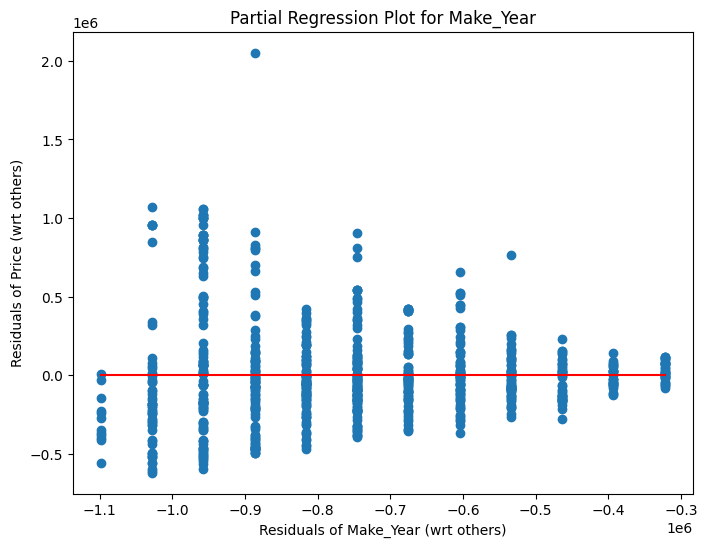

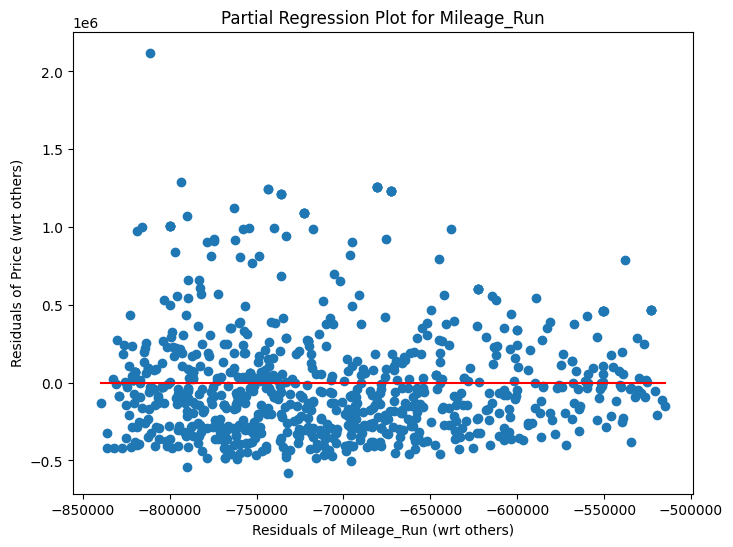

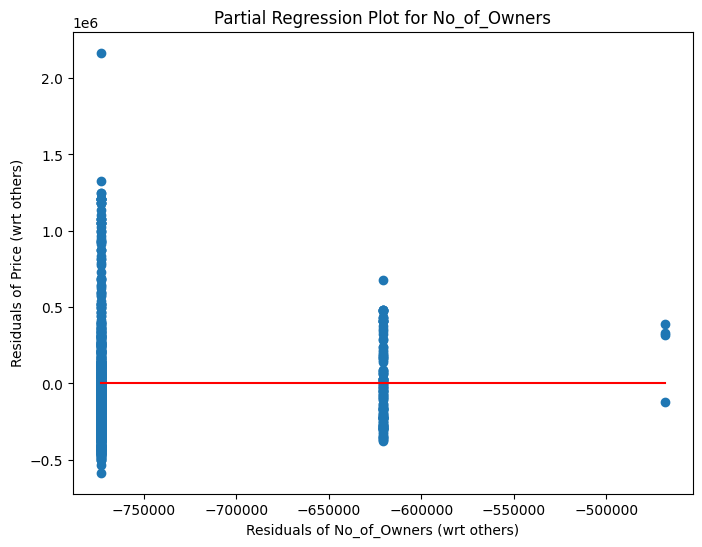

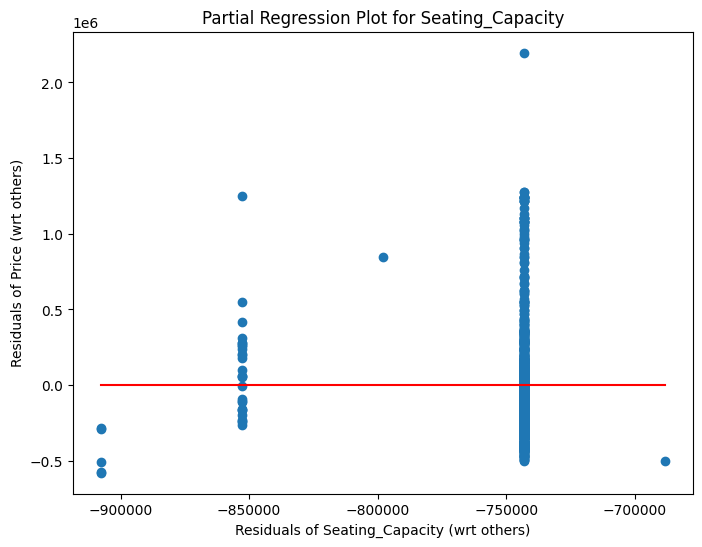

In [17]:
# List of numerical columns for which to plot partial regression plots
numerical_cols = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity']

# Iterate through each numerical column and create a partial regression plot
for col in numerical_cols:
    # Prepare the feature matrix: Select the current numerical column and add a constant term
    X_partial = add_constant(X_train[[col]])

    # Fit a linear regression model
    model = OLS(y_train, X_partial).fit()

    # Get the partial regression data: residuals of y and X with respect to other variables
    y_resid = model.resid  # Residuals of y

    # Calculate residuals for the independent variable
    X_resid = X_train[col] - model.predict(X_partial)

    # Create and display the partial regression plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_resid, y_resid)
    plt.title(f'Partial Regression Plot for {col}')
    plt.xlabel(f'Residuals of {col} (wrt others)')
    plt.ylabel('Residuals of Price (wrt others)')

    # Add a line of best fit to highlight any linear trend
    coef = np.polyfit(X_resid, y_resid, 1)
    plt.plot(np.unique(X_resid), np.poly1d(coef)(np.unique(X_resid)), color='red')

    plt.show()


5. Yes, there are noticeable non-linearities in these partial regression plots. There is a significant non-linearity is evident in the Mileage_Run plot.

In [18]:
# Add polynomial terms for `Mileage_Run`, `No_of_Owners` and `Seating_Capacity`
X_train['Mileage_Run_sq'] = X_train['Mileage_Run']**2
X_train['No_of_Owners_sq'] = X_train['No_of_Owners']**2
X_train['Seating_Capacity_sq'] = X_train['Seating_Capacity']**2

X_test['Mileage_Run_sq'] = X_test['Mileage_Run']**2
X_test['No_of_Owners_sq'] = X_test['No_of_Owners']**2
X_test['Seating_Capacity_sq'] = X_test['Seating_Capacity']**2

# Instantiate the Linear Regression model
model_complex = LinearRegression()

# Fit the model with the training data
model_complex.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred_complex = model_complex.predict(X_train)
y_test_pred_complex = model_complex.predict(X_test)

# Evaluate the model's performance
rmse_train_complex = np.sqrt(mean_squared_error(y_train, y_train_pred_complex))
rmse_test_complex = np.sqrt(mean_squared_error(y_test, y_test_pred_complex))
r2_train_complex = r2_score(y_train, y_train_pred_complex)
r2_test_complex = r2_score(y_test, y_test_pred_complex)

# Print the model's performance metrics
print("\nComplex Linear Regression Model Performance:")
print(f"Training Set - RMSE: {rmse_train_complex:.2f}, R^2: {r2_train_complex:.2f}")
print(f"Test Set - RMSE: {rmse_test_complex:.2f}, R^2: {r2_test_complex:.2f}")


Complex Linear Regression Model Performance:
Training Set - RMSE: 139884.13, R^2: 0.86
Test Set - RMSE: 143233.70, R^2: 0.82


6. The more complex model, which incorporated polynomial terms to capture non-linear relationships, shows a marginal improvement in performance compared to the simpler linear model.

On the training set, the complex model achieved a lower RMSE (139884.13 vs. 142154.19), indicating a slightly better fit to the training data. However, both models have the same R^2 (0.86), meaning they explain the same amount of variance.

On the test set, the complex model also exhibits a slightly lower RMSE (143233.70 vs. 143815.30) and a marginally higher R^2 (0.82 vs. 0.82), suggesting a slight improvement in generalization to unseen data.

Overall, while the complex model does demonstrate a slightly better fit and generalization, the improvement is not dramatic. This suggests that the simpler linear model already captured a significant portion of the underlying relationships in the data, and the added complexity provides only a modest benefit in terms of predictive accuracy.

7.
Learnings About Overfitting, Underfitting, and Model Selection

Underfitting: Neither model appears to be significantly underfitting. Underfitting would be indicated by poor performance on both the training and test sets. Both models achieve reasonably high R^2 values and relatively low RMSE values, suggesting they capture the underlying patterns in the data to a good extent.

Overfitting: The simpler model shows minimal overfitting because its performance on the training and test sets is quite similar. The complex model shows a slightly greater tendency to overfit, as it performs better on the training set than on the test set. However, the difference is small, indicating that the overfitting is not severe.

Model Selection:
Model selection involves choosing the best model from a set of candidate models. In this case, we compared a simpler linear model with a more complex polynomial model.

The analysis suggests that the simpler model might be preferable. While the complex model reduces the training error, the improvement in test set performance is marginal. The simpler model is more parsimonious (simpler) and less prone to overfitting, making it a better choice for generalization.
The principle of parsimony (Occam's razor) favors simpler models when they perform comparably to more complex ones.

The trade-off between model complexity and generalization is a key consideration in model selection. Adding complexity (more features, higher-order terms) can improve training set performance but might not always lead to better generalization.

In summary, the analysis highlights the importance of EDA, feature engineering, and model evaluation. It demonstrates how partial correlation plots can guide model development by revealing non-linearities. It also provides insights into the concepts of overfitting and underfitting and illustrates the importance of model selection based on both performance and parsimony.